## Generative Adversarial Network (GAN) with Python and Tensorflow

### Import dependencies

In [26]:
# dataset and visualization components
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import numpy as np

# modeling components
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D

### Load and visualize data

In [27]:
# Load the mnist dataset from tensorflow_datasets
ds = tfds.load('mnist', split='train')

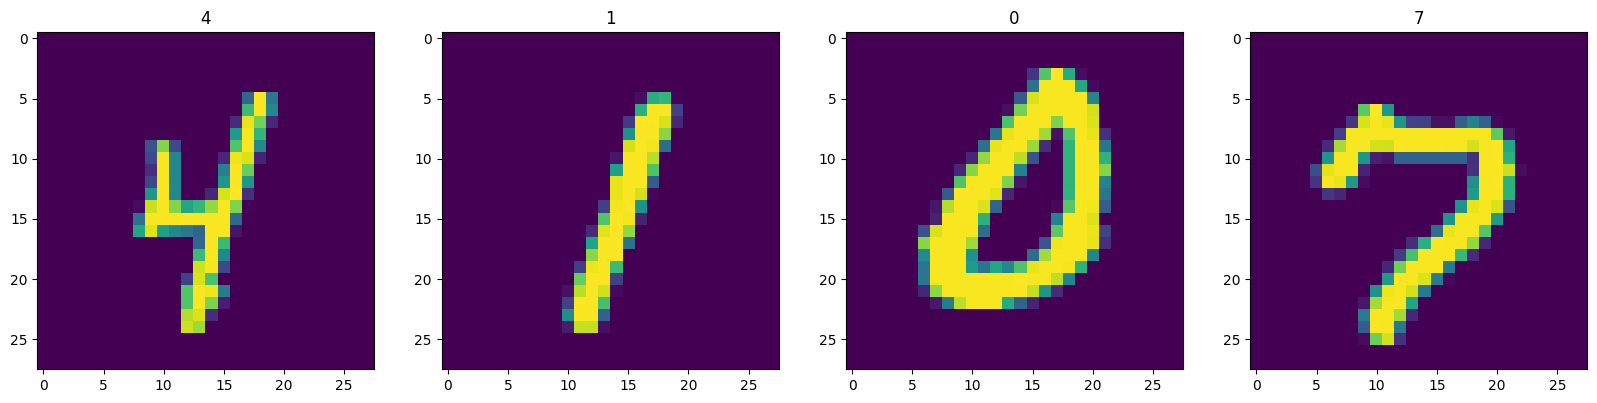

In [28]:
# Convert the data to a numpy iterator
data_iterator = ds.as_numpy_iterator()

# Visualize the data
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    # Grab an image and label
    sample = data_iterator.next()
    ax[idx].imshow(np.squeeze(sample['image']))
    ax[idx].title.set_text(sample['label'])

### Pre-process data

In [29]:
# Scale all the images
def scale_images(data): 
    image = data['image']
    return image / 255

In [30]:
# Running the dataset through the scale_images preprocessing step
ds = ds.map(scale_images) 
# Cache the dataset for that batch 
ds = ds.cache()
# Shuffle it up 
ds = ds.shuffle(60000)
# Batch into 128 images per sample
ds = ds.batch(128)
# Reduces the likelihood of bottlenecking 
ds = ds.prefetch(64)

In [31]:
ds.as_numpy_iterator().next().shape

(128, 28, 28, 1)

### Build the generator

In [32]:
def build_generator():
    model = Sequential()                       # define our model
    model.add(Dense(7*7*128, input_dim=128))   # add Dense layer with random noise as input
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation
    model.add(Reshape((7,7,128)))              # reshape to 17*17*128

    # Upsampling block - 1
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Upsampling block - 2
    model.add(UpSampling2D())                  # layer used to increase the spatial resolution of the input
    model.add(Conv2D(128, 5, padding='same'))  # convolutional nn layer with 128 units, kernel size 5x5 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 1
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # Downsampling block - 2
    model.add(Conv2D(128, 4, padding='same'))  # convolutional nn layer with 128 units, kernel size 4x4 and padding same
    model.add(LeakyReLU(0.2))                  # apply LeakyRelu activation

    # convolutional nn layer to change to 1 channel,kernel size 4x4, same padding and a sigmoid activation this time
    model.add(Conv2D(1, 4, padding='same', activation='sigmoid'))

    # return the model
    return model

In [33]:
# generator summary
generator = build_generator()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 6272)              809088    
                                                                 
 leaky_re_lu_14 (LeakyReLU)  (None, 6272)              0         
                                                                 
 reshape_2 (Reshape)         (None, 7, 7, 128)         0         
                                                                 
 up_sampling2d_4 (UpSampling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 14, 14, 128)       409728    
                                                                 
 leaky_re_lu_15 (LeakyReLU)  (None, 14, 14, 128)       0         
                                                      

### Test the generator

1/1 [==============================] - 0s 66ms/step


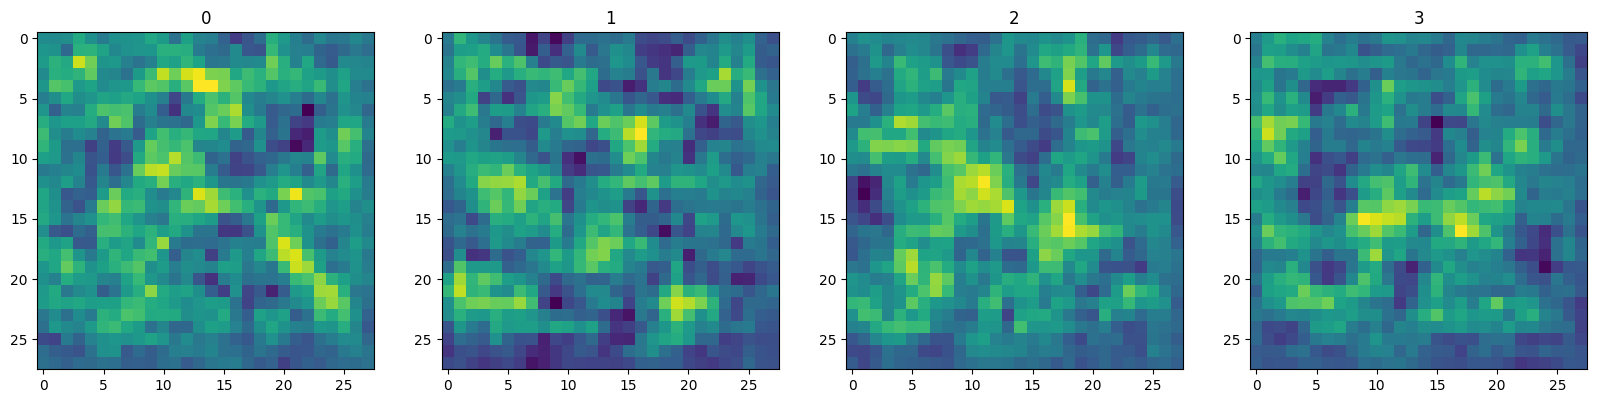

In [34]:
# Generate 4 new images
img = generator.predict(np.random.randn(4,128,1))

# Setup the subplot formatting 
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
# Loop 4 times and get images 
for idx, img in enumerate(img): 
    # Plot the image using a specific subplot 
    ax[idx].imshow(np.squeeze(img))
    ax[idx].title.set_text(idx)

### Build the discriminator

In [35]:
def build_discriminator(): 
    model = Sequential()
    
    # First Conv Block
    model.add(Conv2D(32, 5, input_shape = (28,28,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Second Conv Block
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Third Conv Block
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Fourth Conv Block
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    
    return model 

In [36]:
# discriminator summary
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 24, 24, 32)        832       
                                                                 
 leaky_re_lu_19 (LeakyReLU)  (None, 24, 24, 32)        0         
                                                                 
 dropout_5 (Dropout)         (None, 24, 24, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 20, 20, 64)        51264     
                                                                 
 leaky_re_lu_20 (LeakyReLU)  (None, 20, 20, 64)        0         
                                                                 
 dropout_6 (Dropout)         (None, 20, 20, 64)        0         
                                                                 
 conv2d_21 (Conv2D)          (None, 16, 16, 128)      

### Test the discriminator

In [43]:
# generate 4 images
img = generator.predict(np.random.randn(4,128,1))
# use the discriminator to predict the images made by the generator
discriminator.predict(img)

1/1 [==============================] - 0s 18ms/step


array([[0.501965  ],
       [0.50205153],
       [0.50186646],
       [0.5017828 ]], dtype=float32)